# About this example

This example shows how you can run a Facenet model to perform Facial Recognition with confidentiality guarantees. 

By using BlindAI, people can send data for the AI to analyze their biometric data without having to fear privacy leaks.

Facenet is a state-of-the art ResNet model for Facial Recogntion. You can learn more about it on [Facenet repository](https://github.com/timesler/facenet-pytorch).

# Installing dependencies

Install the dependencies this example needs.

In [ ]:
!pip install -q transformers[onnx] torch

Install the Facenet-pytorch library.

In [ ]:
!pip install facenet-pytorch

Install the latest version of BlindAI.

In [ ]:
!pip install blindai

# Preparing the model

The first step here is to prepare the model to perform facial recognition. 

To make it simpler, we will do an example where we will hardcode the database of biometric templates in the neural network itself. This works if the database of people to identify is fixed. For more dynamic workload, BlindAI can be adapted to suit this use case but we will not cover it here

First we load the pretrained Facenet model.

In [1]:
from facenet_pytorch import InceptionResnetV1
import torch

resnet = InceptionResnetV1(pretrained='vggface2').eval()

We then download the people that will serve as our biometric database. The goal here is to use a neural network to see if a new person to be identified belongs to one of the three people registered.

In [3]:
!wget https://raw.githubusercontent.com/mithril-security/blindai/master/examples/facenet/woman_0.jpg
!wget https://raw.githubusercontent.com/mithril-security/blindai/master/examples/facenet/woman_1.jpg
!wget https://raw.githubusercontent.com/mithril-security/blindai/master/examples/facenet/woman_2.jpg

--2022-06-06 16:24:34--  https://raw.githubusercontent.com/mithril-security/blindai/master/examples/facenet/woman_0.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4853 (4.7K) [image/jpeg]
Saving to: ‘woman_0.jpg’

woman_0.jpg         100%[===================>]   4.74K  --.-KB/s    in 0s      

2022-06-06 16:24:34 (32.3 MB/s) - ‘woman_0.jpg’ saved [4853/4853]

--2022-06-06 16:24:34--  https://raw.githubusercontent.com/mithril-security/blindai/master/examples/facenet/woman_1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4

We can have a look at our dataset. 

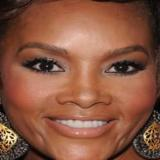

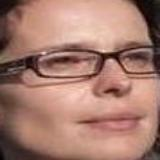

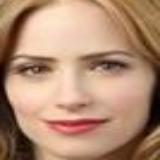

(None, None, None)

In [2]:
from PIL import Image

files = [f"woman_{i}.jpg" for i in range(3)]
Image.open(files[0]).show(), Image.open(files[1]).show(), Image.open(files[2]).show()

Here we will do the enrollment phase, i.e. extract a template from each person, and store it. Those templates will be used as references to compute a similarity score when someone new comes in to be identified.

In [3]:
import numpy as np

embeddings = []

for file in files:
    # We open each file and preprocess it
    im = Image.open(file)
    im = torch.tensor(np.asarray(im)).permute(2,0,1).unsqueeze(0) / 128.0 - 1
    
    # We make the tensor go through the ResNet to extract a template
    embedding = resnet(im)
    embeddings.append(embedding.squeeze(0))
    
# We stack everything in a matrix
embeddings = torch.stack(embeddings)

Because the scoring will be done through a dot product of a new candidate template with the registered templates, we can implement this scoring as a matrix multiplication between the registered tempalte and the new template:

In [4]:
import torch.nn as nn

# Create the scoring layer with a matrix multiplication
scoring_layer = nn.Linear(512, 3, bias=False)

# Store the computed embeddings inside
scoring_layer.weight.data = embeddings

full_network = nn.Sequential(
    resnet,
    scoring_layer
)

Before sending our model to BlindAI, we will how it performs in practice.

Let's download a test set, containing a different picture of the second woman we registered.

In [10]:
!wget https://raw.githubusercontent.com/mithril-security/blindai/master/examples/facenet/woman_test.jpg

--2022-06-06 16:43:53--  https://raw.githubusercontent.com/mithril-security/blindai/master/examples/facenet/woman_test.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3856 (3.8K) [image/jpeg]
Saving to: ‘woman_test.jpg.1’

woman_test.jpg.1    100%[===================>]   3.77K  --.-KB/s    in 0s      

2022-06-06 16:43:54 (46.9 MB/s) - ‘woman_test.jpg.1’ saved [3856/3856]



We can see below that the two pictures are indeed from the same person.

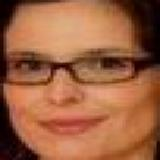

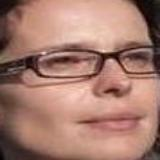

(None, None)

In [18]:
test_im = Image.open("woman_test.jpg")
test_im.show(), Image.open("woman_1.jpg").show()

We can now apply our full network, which will extract a template from the test image, and compute a dot product between the new templates and the registered templates.

In [19]:
test_im = torch.tensor(np.asarray(test_im)).permute(2,0,1).unsqueeze(0) / 128.0 - 1

scores = full_network(test_im)

We can see that the scores reflect the truth: the dot product of the embeddings of the test image with the first and third women are low, while the score is high with the second woman. This makes sense, as the neural network was trained to provide a high score for pictures of the same person, and make the score low for different people.

In [20]:
scores

tensor([[-0.0349,  0.7551,  0.0737]], grad_fn=<MmBackward0>)

Now we can export the model to be fed to BlindAI to deploy it with privacy guarantees.

In [9]:
torch.onnx.export(full_network,               # model being run
                  test_im,                         # model input (or a tuple for multiple inputs)
                  "facenet.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
)

# Deployment on BlindAI

Please make sure the **server is running**. To launch the server, refer to the [Launching the server](https://docs.mithrilsecurity.io/getting-started/quick-start/run-the-blindai-server) documentation page. 

If you have followed the steps and have the Docker image ready, this mean you simply have to run `docker run -it -p 50051:50051 -p 50052:50052 mithrilsecuritysas/blindai-server-sim:latest`

So the first thing we need to do is to connect securely to the BlindAI server instance. Here we will use simulation mode for ease of use. This means that we do not leverage the hardware security propertiers of secure enclaves, but we do not need to run the Docker image with a specific hardware.

If you wish to run this example in hardware mode, you need to prepare the `host_server.pem` and `policy.toml` files. Learn more on the [Deploy on Hardware](https://docs.mithrilsecurity.io/getting-started/deploy-on-hardware) documentation page. 

In [ ]:
from blindai.client import BlindAiClient, ModelDatumType

# Launch client
client = BlindAiClient()

# Simulation mode
client.connect_server(addr="localhost", simulation=True)

# Hardware mode
# client.connect_server(addr="localhost", policy="./policy.toml", certificate="./host_server.pem")

Then, upload the model inside the BlindAI server. This simply means uploading the ONNX file created before.

When uploading the model, we have to precise the shape of the input and the data type. 

In this case, because we use a ResNet model, we will need to send floats for the facial data. As the outputs are scores, we will accept floats as well for output.

In [ ]:
client.upload_model(model="./facenet.onnx", shape=test_im.shape, 
                    dtype=ModelDatumType.F32, dtype_out=ModelDatumType.F32)

# Sending data for confidential prediction

Now it's time to check it's working live!

We will just prepare some input for the model inside the secure enclave of BlindAI to process it.

First we prepare our input data, the test image we used before.

In [ ]:
from PIL import Image
import torch

test_im = Image.open("woman_test.jpg")
test_im = torch.tensor(np.asarray(test_im)).permute(2,0,1).unsqueeze(0) / 128.0 - 1

Now we can send the audio data to be processed confidentially!

In [ ]:
response = client.run_model(test_im.flatten().tolist())